In [1]:
def __clear_env():
    for key in globals().keys():
        if not key.startswith("__"):# 排除系统内建函数
            globals().pop(key)
__clear_env
import example_pendulum
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
#import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import csv

from torch.autograd import Variable

1.1082981121129995e-43


In [2]:
device = 'cuda:3'
data = example_pendulum.get_pendulum_data(10)
image = data['x']
image_t = data['dx']
image_tt = data['ddx']
angle = data['z']
angle_t = data['dz']
angle_tt = data['ddz']
print(image.shape)

(5000, 2601)


In [3]:
environment = "server"
loss_log = []
params = {}
#params['learning_rate'] = trial.suggest_float('lr',0,1)
params['epochs'] = 170
params['batch_size'] = 500
if environment == 'laptop':
    params['root_dir'] =R'C:\Users\87106\OneDrive\sindy\progress\Angle_t_extractor'
elif environment == 'desktop':
    params['root_dir'] = R'E:\OneDrive\sindy\progress\Angle_t_extractor'
elif environment == 'server':
    params['root_dir'] = R'/mnt/ssd1/stilrmy/Angle_extractor/progress/Angle_t_extractor'
params['learning_rate'] = 1e-7

# save parameters
params['if_save'] = True
params['save_date'] = '4-21'
params['save_ver'] = '1'
#load parameters
params['if_load'] = False
params['load_date'] = '4-7'
params['load_ver'] = '1'
PATH = os.path.join(params['root_dir'], params['save_date'],params['save_ver'])
loading_path = os.path.join(params['root_dir'], params['load_date'],params['load_ver'],'model.pth')
print(loading_path)

/mnt/ssd1/stilrmy/Angle_extractor/progress/Angle_t_extractor/4-7/1/model.pth


In [10]:
class angle_predict(nn.Module):
    def __init__(self):
        super(angle_predict, self).__init__()
        self.fc1 = nn.Linear(7803, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 64)
        self.fc6 = nn.Linear(64, 1)
    def forward(self, x):
        m = nn.ReLU()
        x = self.fc1(x)
        x = m(x)
        x = self.fc2(x)
        x = m(x)
        x = self.fc3(x)
        x = m(x)
        x = self.fc4(x)
        x = m(x)
        x = self.fc5(x)
        x = m(x)
        x = self.fc6(x) 
        return x
model = angle_predict()
if params['if_load'] == True:
    model.load_state_dict(torch.load(loading_path))
model = model.to(device)

In [14]:
opt = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
for epoch in range(params['epochs']):
    loss_sum = 0
    loss_angle_sum = 0
    loss_angle_t_sum = 0
    loss_angle_tt_sum = 0
    count = 0 
    model.train()
    for i in range(len(data['z'])//params['batch_size']):
        image_temp = image[i*params['batch_size']:(i+1)*params['batch_size'],:]
        angle_t_temp = angle_t[i*params['batch_size']:(i+1)*params['batch_size']]
        for j in range(image_temp.shape[0]-2):
            input = torch.tensor(image_temp[j:j+3,:],dtype=torch.float32).to(device)
            input = input.view(-1)
            input = Variable(input)
            pre = model.forward(input)
            angle_t_true = torch.tensor(angle_t_temp[j],dtype=torch.float32).to(device)
            loss_angle_t = torch.abs(angle_t_true - pre)
            loss = loss_angle_t
            loss_sum += loss
            count += 1
            opt.zero_grad()
            loss.backward()
            opt.step()
        model.eval()
    loss_log.append(loss_sum.item()/count)
    print('epoch: ', epoch+1, 'loss: ', loss_sum.item()/count,)

epoch:  1 loss:  0.028978260453925077
epoch:  2 loss:  0.03193271744203376
epoch:  3 loss:  0.03104567010718656
epoch:  4 loss:  0.030198176127361007
epoch:  5 loss:  0.03211431235194685
epoch:  6 loss:  0.03088021335831608
epoch:  7 loss:  0.02722521555950364
epoch:  8 loss:  0.03023595848236697
epoch:  9 loss:  0.029249456321379267
epoch:  10 loss:  0.028093765442629894
epoch:  11 loss:  0.02762217081215487
epoch:  12 loss:  0.030021177238249874
epoch:  13 loss:  0.032040160152328065
epoch:  14 loss:  0.029778593132294803
epoch:  15 loss:  0.02777323282387362
epoch:  16 loss:  0.028346638507153615
epoch:  17 loss:  0.03006596086494415
epoch:  18 loss:  0.031137075768895895
epoch:  19 loss:  0.02850521348087663
epoch:  20 loss:  0.02811105260887299
epoch:  21 loss:  0.02953711513534607
epoch:  22 loss:  0.029022176964694717
epoch:  23 loss:  0.03093725610449611
epoch:  24 loss:  0.03234561475884005
epoch:  25 loss:  0.027126149863124373
epoch:  26 loss:  0.029418850328070092
epoch:  2

In [15]:
def saving(model,PATH):
    if os.path.exists(PATH) == False:
        os.makedirs(PATH)
    model_PATH = os.path.join(PATH, 'model.pth')
    torch.save(model.state_dict(), model_PATH)
    params_PATH = os.path.join(PATH, 'params.txt')
    with open(params_PATH, 'w') as f:
        f.write(str(params))
        f.close()
    loss_PATH = os.path.join(PATH, 'loss_log.csv')
    with open(loss_PATH, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(loss_log)
    #fig_PATH = os.path.join(PATH, 'loss.png') 
    #plt.savefig(fig_PATH)
    print("data saved")
    return

In [16]:
if params['if_save'] == True:
    saving(model,PATH)

data saved


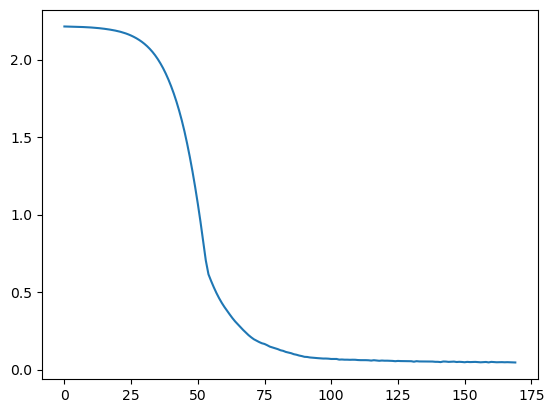

In [8]:
#plotting result
plt.plot(loss_log)
fig_PATH = os.path.join(PATH, 'loss.png') 
plt.savefig(fig_PATH, bbox_inches='tight', pad_inches = +0.1)
plt.show()